<a href="https://colab.research.google.com/github/MarcosVeniciu/Inception_V1/blob/main/BN_Inception_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Artigo Batch Normalizatio: https://arxiv.org/pdf/1502.03167v3.pdf
# Artigo Inception V1: https://ai.plainenglish.io/googlenet-inceptionv1-with-tensorflow-9e7f3a161e87
# Codigo de referencia: https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v1.py
# Outras referencias de codigo: https://paperswithcode.com/paper/going-deeper-with-convolutions

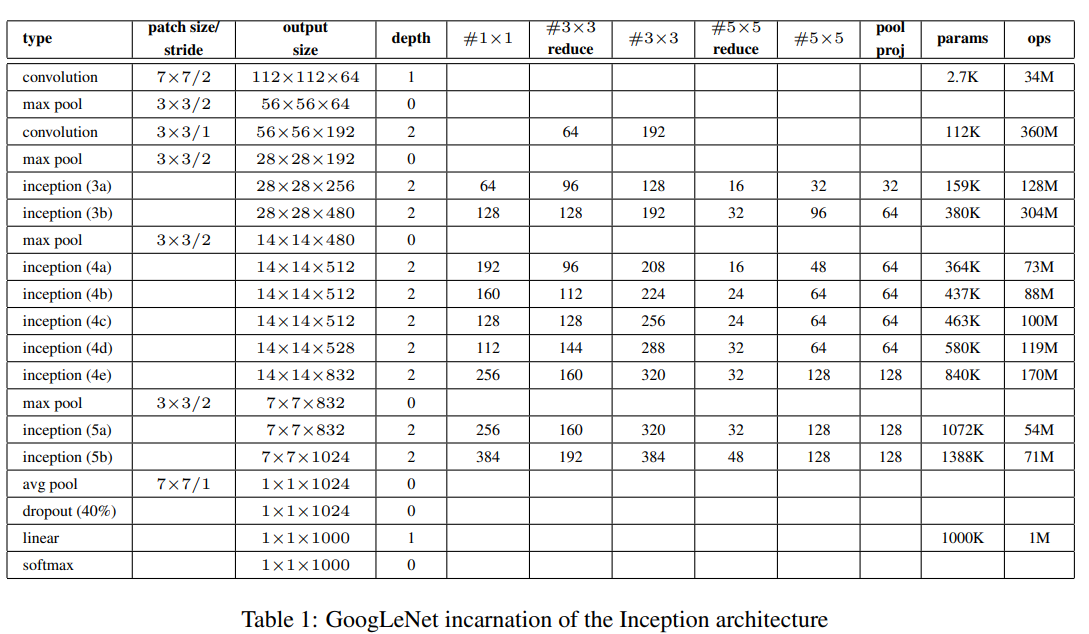

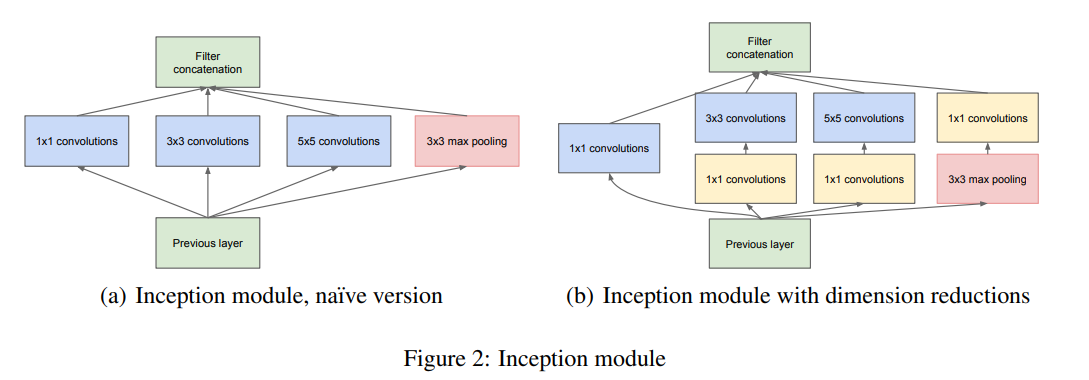

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import tensorflow_datasets as tfds
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf
import numpy as np
import cv2

print(tf.__version__) # 2.12.0 (12/5/2023)

2.12.0


In [3]:
img_rows,img_cols = 224, 224
image_size = (img_rows, img_cols)
input_shape = image_size + (1,)
batch_size = 128
num_classes = 10

# Dataset

In [4]:
# Load training and validation sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Resize images to 244x244
X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:][:10000]])
X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:,:,:,:][:5000]])
y_train = y_train[:10000]
y_test = y_test[:5000]

# Transform targets to keras compatible format
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Making all the values range between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, y_train.shape, X_test.shape, y_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((10000, 224, 224), (10000, 10), (5000, 224, 224), (5000, 10))

# Modelo

In [5]:
# Ob1: No artigo na primeira camada conv é 1x1 e na segunda é 5x5, no codigo é 1x1, e depois 3x3. MANTIVE O DO ARTIGO
# Ob2: No codigo de referencia foi usado axis=3. Mantive o do código.
# Ob3: A saida da Conv é 4, 4, 128, então usie uma camada Flatten pra transformar isso em um vetor
# Ob4: Originalmente não havia a camada Flatten, porem a saida da ultima AveragePooling2D é (None, 1, 1, 1024) 
#      o que teve problema com a camada densa de classificação, que ficava como (None, 1, 1, 10) sendo que deveria ser (None, 10) 
# Ob5: No artigo sobre BatchNormalization na seção 3.2 Batch-Normalized Convolutional Network diz que a BN é aplicada antes da relu, normalizando apenas x = Wu+ b.

## Blocos

In [6]:
def conv_bn(input, filters, kernel_size, name):
  x = layers.Conv2D(filters=filters, kernel_size = kernel_size, padding='same', name=name)(input)
  x = layers.BatchNormalization()(x) #Ob5
  x = layers.Activation('relu')(x)
  return x

In [7]:
def inception_3a(previous_layer):
  branch_0 = conv_bn(previous_layer, 64, [1,1], 'Inception_3a_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 96, [1,1], 'Inception_3a_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 128, [3,3], 'Inception_3a_Conv_3x3')


  branch_2 = conv_bn(previous_layer, 16, [1,1], 'Inception_3a_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 32, [5,5], 'Inception_3a_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_3a_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 32, [1,1], 'Inception_3a_Conv_1x1_pool_porj')

  # Concat
  return tf.concat(values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_3a') # Ob2



def inception_3b(previous_layer):
  branch_0 = conv_bn(previous_layer, 128, [1,1], 'Inception_3b_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 128, [1,1], 'Inception_3b_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 192, [3,3], 'Inception_3b_Conv_3x3')

  branch_2 = conv_bn(previous_layer, 32, [1,1], 'Inception_3b_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 96, [5,5], 'Inception_3b_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_3b_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 64, [1,1], 'Inception_3b_Conv_1x1_pool_porj')

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_3b') # Ob2

In [8]:
def inception_4a(previous_layer):
  branch_0 = conv_bn(previous_layer, 192, [1,1], 'Inception_4a_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 96, [1,1], 'Inception_4a_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 208, [3,3], 'Inception_4a_Conv_3x3')

  branch_2 = conv_bn(previous_layer, 16, [1,1], 'Inception_4a_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 48, [5,5], 'Inception_4a_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4a_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 64, [1,1], 'Inception_4a_Conv_1x1_pool_porj')

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4a') # Ob2



def inception_4b(previous_layer):
  branch_0 = conv_bn(previous_layer, 160, [1,1], 'Inception_4b_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 112, [1,1], 'Inception_4b_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 224, [3,3], 'Inception_4b_Conv_3x3')

  branch_2 = conv_bn(previous_layer, 24, [1,1], 'Inception_4b_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 64, [5,5], 'Inception_4b_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4b_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 64, [1,1], 'Inception_4b_Conv_1x1_pool_porj')

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4b') # Ob2



def inception_4c(previous_layer):
  branch_0 = conv_bn(previous_layer, 128, [1,1], 'Inception_4c_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 128, [1,1], 'Inception_4c_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 256, [3,3], 'Inception_4c_Conv_3x3')

  branch_2 = conv_bn(previous_layer, 24, [1,1], 'Inception_4c_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 64, [5,5], 'Inception_4c_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4c_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 64, [1,1], 'Inception_4c_Conv_1x1_pool_porj')

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4c') # Ob2



def inception_4d(previous_layer):
  branch_0 = conv_bn(previous_layer, 112, [1,1], 'Inception_4d_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 144, [1,1], 'Inception_4d_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 288, [3,3], 'Inception_4d_Conv_3x3')

  branch_2 = conv_bn(previous_layer, 32, [1,1], 'Inception_4d_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 64, [5,5], 'Inception_4d_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4d_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 64, [1,1], 'Inception_4d_Conv_1x1_pool_porj')

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4d') # Ob2

def inception_4e(previous_layer):
  branch_0 = conv_bn(previous_layer, 256, [1,1], 'Inception_4e_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 160, [1,1], 'Inception_4e_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 320, [3,3], 'Inception_4e_Conv_3x3')

  branch_2 = conv_bn(previous_layer, 32, [1,1], 'Inception_4e_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 128, [5,5], 'Inception_4e_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_4e_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 128, [1,1], 'Inception_4e_Conv_1x1_pool_porj')

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_4e') # Ob2

In [9]:
def inception_5a(previous_layer):
  branch_0 = conv_bn(previous_layer, 256, [1,1], 'Inception_5a_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 160, [1,1], 'Inception_5a_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 320, [3,3], 'Inception_5a_Conv_3x3')

  branch_2 = conv_bn(previous_layer, 32, [1,1], 'Inception_5a_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 128, [5,5], 'Inception_5a_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_5a_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 128, [1,1], 'Inception_5a_Conv_1x1_pool_porj')

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_5a') # Ob2



def inception_5b(previous_layer):
  branch_0 = conv_bn(previous_layer, 384, [1,1], 'Inception_5b_Conv_1x1')
  
  branch_1 = conv_bn(previous_layer, 192, [1,1], 'Inception_5b_Conv_3x3_reduce')
  branch_1 = conv_bn(branch_1, 384, [3,3], 'Inception_5b_Conv_3x3')

  branch_2 = conv_bn(previous_layer, 48, [1,1], 'Inception_5b_Conv_5x5_reduce')
  branch_2 = conv_bn(branch_2, 128, [5,5], 'Inception_5b_Conv_5x5') # Ob1

  branch_3 = layers.MaxPool2D(pool_size = [3,3], strides=(1, 1), padding='same', name='Inception_5b_MaxPool_3x3')(previous_layer)
  branch_3 = conv_bn(branch_3, 128, [1,1], 'Inception_5b_Conv_1x1_pool_porj')

  # Concat
  return tf.concat( values=[branch_0, branch_1, branch_2, branch_3], axis=3, name='concat_Inception_5b') # Ob2

## Rede

In [10]:
def inception_v1(input_shape, num_classes):
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  inputs = keras.Input(shape = input_shape)
  #scale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255) Já esta sendo feito durante a geraçaõ do dataset
  #x = scale_layer(inputs)

  x = layers.Conv2D(filters=64, kernel_size = [7,7], strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x) #Ob5
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = [3,3], strides=2, padding='same')(x)
  x = layers.Conv2D(filters=64, kernel_size = [1,1], strides=1, padding='same')(x)
  x = layers.BatchNormalization()(x) #Ob5
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters=192, kernel_size = [3,3], strides=1, padding='same')(x)
  x = layers.BatchNormalization()(x) #Ob5
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = [3,3], strides=2, padding='same')(x)

  x = inception_3a(x)
  x = inception_3b(x)

  x = layers.MaxPool2D(pool_size = [3,3], strides=2, padding='same')(x)

  x = inception_4a(x)

  # Softmax_0
  outputs_0 = layers.AveragePooling2D(pool_size=(5, 5), strides=3)(x)
  outputs_0 = layers.Conv2D(filters=128, kernel_size = [1,1], strides=1, padding='same')(outputs_0)
  outputs_0 = layers.BatchNormalization()(outputs_0) #Ob5
  outputs_0 = layers.Activation('relu')(outputs_0)
  outputs_0 = keras.layers.Flatten()(outputs_0) #Obs3
  outputs_0 = keras.layers.Dense(1024, activation=activation)(outputs_0)
  outputs_0 = keras.layers.Dropout(rate = 0.7)(outputs_0)
  outputs_0 = keras.layers.Dense(units, activation=activation, name="softmax_0")(outputs_0)



  x = inception_4b(x)
  x = inception_4c(x)

  x = inception_4d(x)

  # Softmax_1
  outputs_1 = layers.AveragePooling2D(pool_size=(5, 5), strides=3)(x)
  outputs_1 = layers.Conv2D(filters=128, kernel_size = [1,1], strides=1, padding='same')(outputs_1)
  outputs_1 = layers.BatchNormalization()(outputs_1) #Ob5
  outputs_1 = layers.Activation('relu')(outputs_1)
  outputs_1 = keras.layers.Flatten()(outputs_1) #Obs3
  outputs_1 = keras.layers.Dense(1024, activation=activation)(outputs_1)
  outputs_1 = keras.layers.Dropout(rate = 0.7)(outputs_1)
  outputs_1 = keras.layers.Dense(units, activation=activation, name="softmax_1")(outputs_1)


  x = inception_4e(x)

  x = layers.MaxPool2D(pool_size = [3,3], strides=2, padding='same')(x)
  
  x = inception_5a(x)
  x = inception_5b(x)  

  # Softmax_2
  x = keras.layers.AveragePooling2D(pool_size=(7, 7), strides=1, name="Olaha_eu")(x)
  x = keras.layers.Flatten()(x) #Obs4
  x = keras.layers.Dropout(rate = 0.4)(x)
  outputs_2 = keras.layers.Dense(units, activation=activation, name="softmax_2")(x)

  return keras.Model(inputs, [outputs_2, outputs_1, outputs_0], name="Inception_V1")

In [11]:
modelo_view = inception_v1(input_shape, num_classes)  

In [12]:
modelo_view.summary()

Model: "Inception_V1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                      

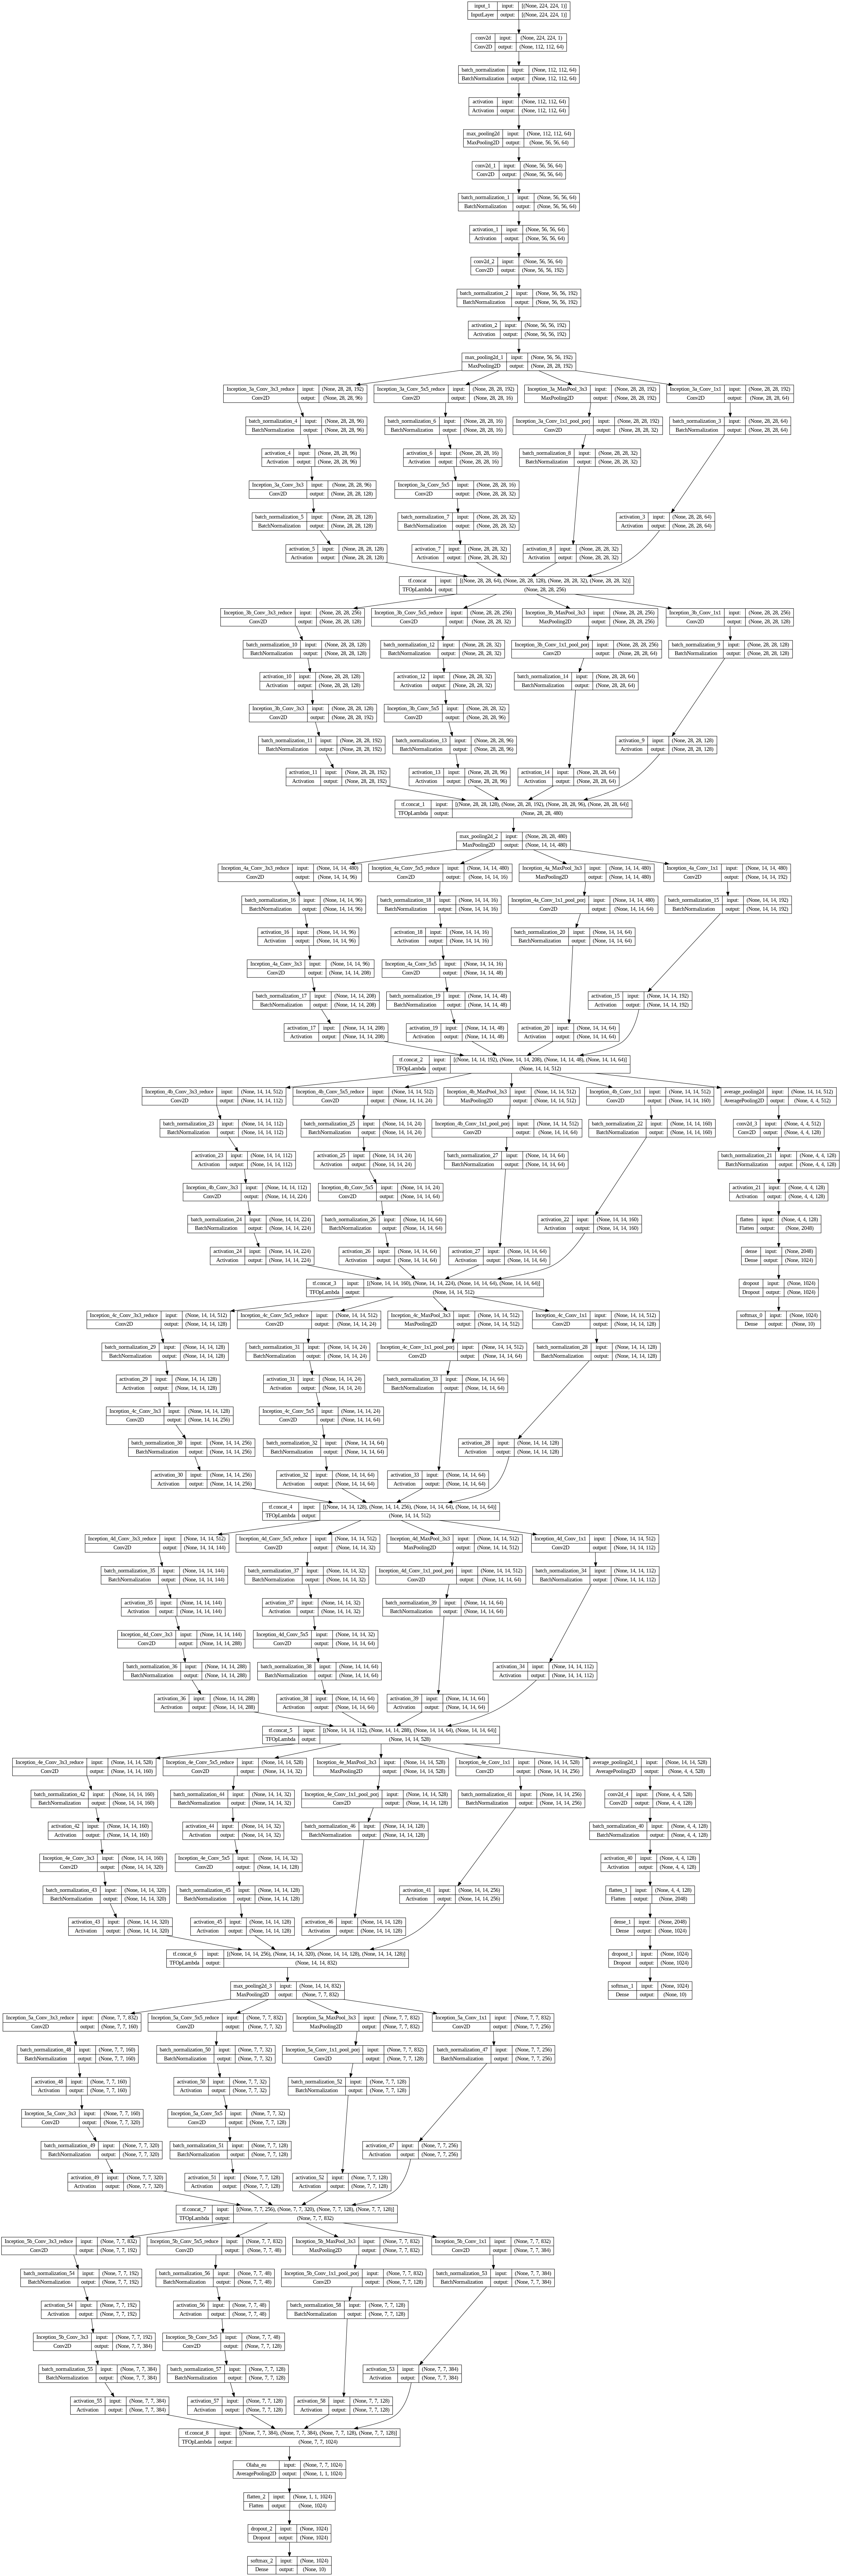

In [13]:
keras.utils.plot_model(modelo_view, show_shapes=True)

# Treinamento

In [14]:
model = inception_v1(input_shape, num_classes)  
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
              loss= ['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              metrics=['accuracy'])

In [15]:
epocas = 100

!nvidia-smi
historico = model.fit(X_train, [y_train, y_train, y_train],validation_data=(X_test, [y_test, y_test, y_test]), epochs=epocas, batch_size=batch_size)

Fri Jun  2 14:18:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W /  70W |    513MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#sdffffffff

In [16]:
valuate = model.evaluate(X_test, [y_test, y_test, y_test], verbose = 0)

print("Loss geral: " + str(valuate[0]))
print("Loss softmax 0: " + str(valuate[3]))
print("Loss softmax 1: " + str(valuate[2]))
print("Loss softmax 2: " + str(valuate[1]))
print()
print("Acuracia softmax 0: " + str(valuate[6]))
print("Acuracia softmax 1: " + str(valuate[5]))
print("Acuracia softmax 2: " + str(valuate[4]))

Loss geral: 1.5290037393569946
Loss softmax 0: 0.7147849798202515
Loss softmax 1: 0.6366810202598572
Loss softmax 2: 0.17753803730010986

Acuracia softmax 0: 0.8708000183105469
Acuracia softmax 1: 0.9753999710083008
Acuracia softmax 2: 0.9657999873161316


<ipython-input-34-22c97fedf99c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


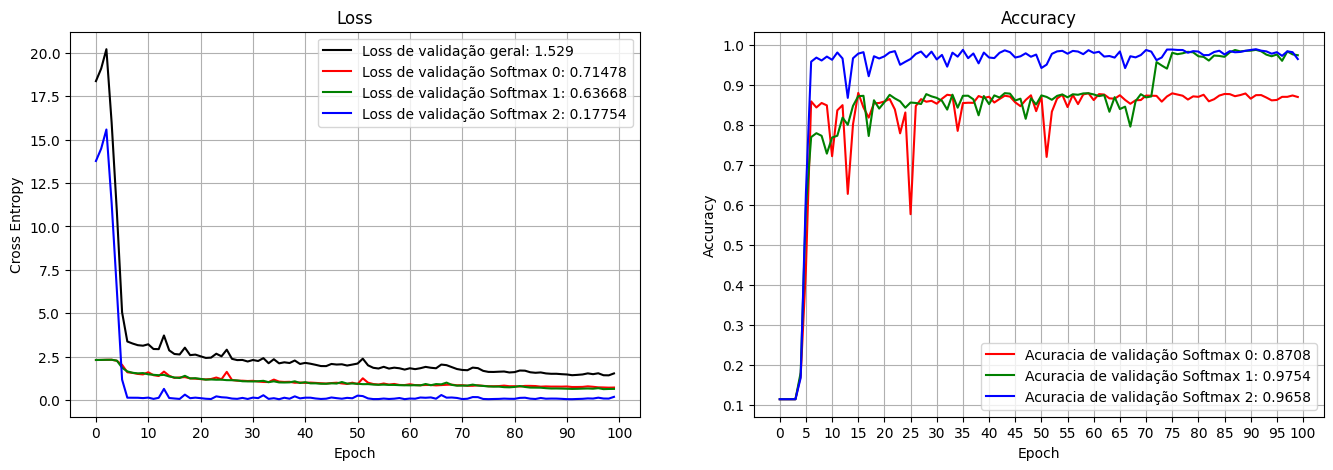

In [34]:
def grafico(historico): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,3,1)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.xticks(np.arange(0, 110, 10))
  plt.plot(historico.history['val_loss'], label='Loss de validação geral: ' + str(round(valuate[0], 5)), color = 'black')
  plt.plot(historico.history['val_softmax_0_loss'], label='Loss de validação Softmax 0: ' + str(round(valuate[3],5)), color = 'Red')
  plt.plot(historico.history['val_softmax_1_loss'], label='Loss de validação Softmax 1: ' + str(round(valuate[2],5)), color = 'green')
  plt.plot(historico.history['val_softmax_2_loss'], label='Loss de validação Softmax 2: ' + str(round(valuate[1],5)), color = 'blue')
  plt.legend()

  # Grafico 2: Acurácia
  plt.subplot(1,3,2)
  plt.title("Accuracy")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.xticks(np.arange(0, 105, 5))
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.plot(historico.history['val_softmax_0_accuracy'], label='Acuracia de validação Softmax 0: '  + str(round(valuate[6],5)), color = 'Red')
  plt.plot(historico.history['val_softmax_1_accuracy'], label='Acuracia de validação Softmax 1: '  + str(round(valuate[5], 5)), color = 'green')
  plt.plot(historico.history['val_softmax_2_accuracy'], label='Acuracia de validação Softmax 2: '  + str(round(valuate[4],5)), color = 'blue')
  plt.legend()

  nome_save = "Treinamento_Inception_V1.jpg"
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()

grafico(historico)

<ipython-input-39-d21017e7d59c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


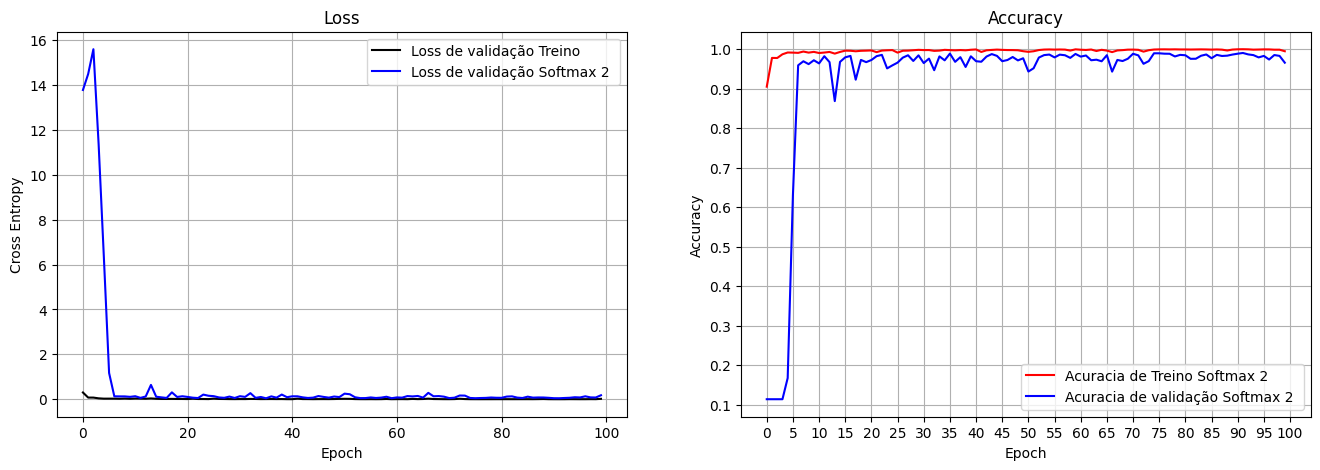

In [39]:
def grafico(historico): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,3,1)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.plot(historico.history['softmax_2_loss'], label='Loss de validação Treino', color = 'black')
  plt.plot(historico.history['val_softmax_2_loss'], label='Loss de validação Softmax 2 ', color = 'blue')
  plt.legend()

  # Grafico 2: Acurácia
  plt.subplot(1,3,2)
  plt.title("Accuracy")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.xticks(np.arange(0, 105, 5))
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.plot(historico.history['softmax_2_accuracy'], label='Acuracia de Treino Softmax 2 ', color = 'Red')
  plt.plot(historico.history['val_softmax_2_accuracy'], label='Acuracia de validação Softmax 2 ', color = 'blue')
  plt.legend()

  nome_save = "Treinamento_Inception_V1_softmax_2.jpg"
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()

grafico(historico)

In [18]:
nome_to_save = "inception_v1_BN.h5"
model.save(nome_to_save)

# Teste

In [19]:
pred = model.predict(X_test)

157/157 [==============================] - 7s 37ms/step


In [20]:
def matriz_confusao(y_true, y_pred, name):
  cm = confusion_matrix(y_true, y_pred)
  cm_display = ConfusionMatrixDisplay(cm).plot()
  name = "Matriz Confusao: " + name + ".jpg"
  #plt.savefig(name)

In [21]:
def metricas(pred, y_test):
  y_pred = []
  y_true = []

  for predicao in pred:
    maior = predicao[0]
    indice = 0
    for i in range(len(predicao)):
      if predicao[i] > maior:
        maior = predicao[i]
        indice = i

    y_pred.append(indice)

  for valor in y_test:
    for i in range(len(valor)):
      if valor[i] == 1:
        y_true.append(i)



  # Cacula a taxa de erro
  certo = 0
  for i in range(len(y_true)):
    if y_pred[i] ==  y_true[i]:
      certo += 1 

  taxa_erro = ((len(y_true) - certo)/len(y_true))*100

  return y_pred, y_true, taxa_erro

Taxa de erro: 3.42%



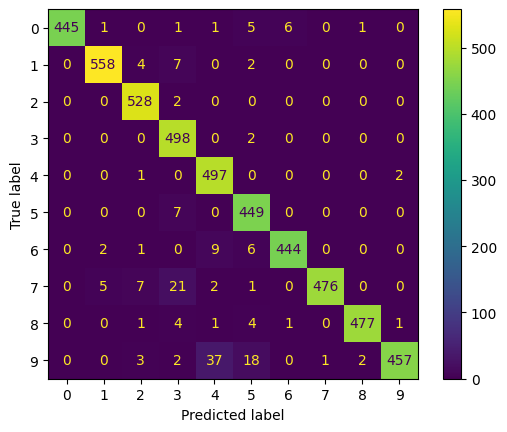

In [22]:
y_pred, y_true, taxa_erro = metricas(pred[0], y_test)
print("Taxa de erro: " + str(taxa_erro) + "%")
print()
matriz_confusao(y_true, y_pred, "teste")

Taxa de erro: 2.46%



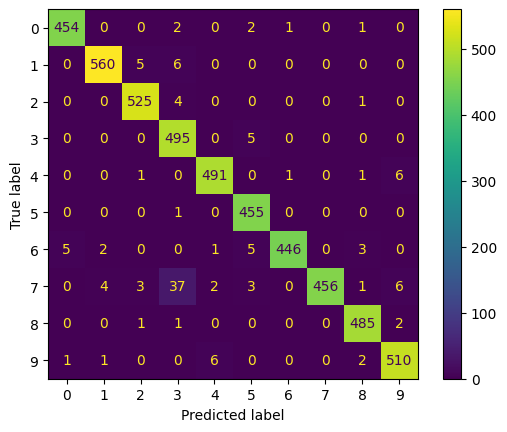

In [23]:
y_pred, y_true, taxa_erro = metricas(pred[1], y_test)
print("Taxa de erro: " + str(taxa_erro) + "%")
print()
matriz_confusao(y_true, y_pred, "teste")

Taxa de erro: 12.920000000000002%



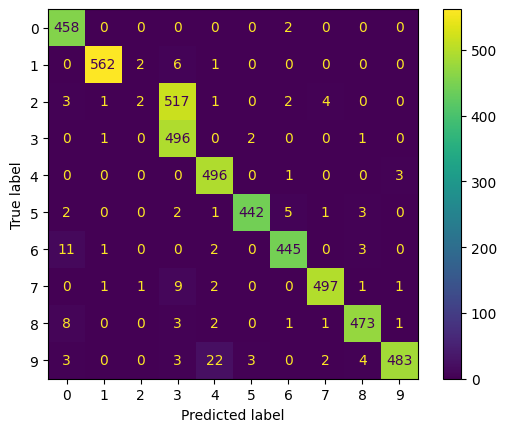

In [24]:
y_pred, y_true, taxa_erro = metricas(pred[2], y_test)
print("Taxa de erro: " + str(taxa_erro) + "%")
print()
matriz_confusao(y_true, y_pred, "teste")